## NIR Tomato Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, signal
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

np.random.seed(42)

## 1. Data Loading and Initial Setup

In [2]:
file_path = 'Tomato_Viavi_Brix_model_pulp.csv'
data = pd.read_csv(file_path)

# Extract features
feature_cols = [col for col in data.columns if col != 'Brix']
X = data[feature_cols]

# Identify spectral wavelength columns
wavelength_cols = [col for col in X.columns if col.replace('.', '').isdigit()]
wavelengths = np.array([float(col) for col in wavelength_cols])

y = data['Brix']

## 2. Data Cleaning and Exploration

In [3]:
print("Dataset Column Information:")
print("==========================")

# Get all non-wavelength columns
non_wavelength_cols = [col for col in X.columns if not col.replace('.', '').isdigit()]

# Display data types for these columns
col_info = X[non_wavelength_cols].dtypes

# Print column info with description
for col, dtype in col_info.items():
    if pd.api.types.is_numeric_dtype(dtype):
        stats = X[col].describe()
        print(f"{col}: {dtype} (Min: {stats['min']:.2f}, Max: {stats['max']:.2f}, Mean: {stats['mean']:.2f})")
    else:
        unique_count = X[col].nunique()
        print(f"{col}: {dtype} (Unique values: {unique_count})")

    missing = X[col].isna().sum()
    if missing > 0:
        print(f"   - Missing values: {missing} ({missing/len(data)*100:.2f}%)")

Dataset Column Information:
Instrument Serial Number: object (Unique values: 1)
Temperature: float64 (Min: 24.12, Max: 32.50, Mean: 27.70)
Notes: object (Unique values: 1)
   - Missing values: 429 (99.31%)
Timestamp: object (Unique values: 131)
Integration Time: float64 (Min: 9.10, Max: 9.10, Mean: 9.10)
SAMPLE NO: object (Unique values: 432)
SAMPLE NO.1: object (Unique values: 28)
plant: object (Unique values: 15)
wetlab ID: object (Unique values: 84)
sample type: object (Unique values: 1)
Lab: object (Unique values: 1)


In [4]:
# Convert 'Timestamp' column to datetime format
X = X.copy()
X['Timestamp'] = pd.to_datetime(X['Timestamp'])

print(f"New dtype of date column: {X['Timestamp'].dtype}")

New dtype of date column: datetime64[ns]


/var/folders/3f/31wd061j4kvc_mzd3wfvw8c00000gn/T/ipykernel_69953/2484967387.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  X['Timestamp'] = pd.to_datetime(X['Timestamp'])


In [5]:
# 1. Checking for uninformative columns
print("Step 1: Checking for uninformative columns...")
columns_to_drop = []

for col in X.columns:
    non_null_count = X[col].count()

    # If column is all null
    if non_null_count == 0:
        columns_to_drop.append(col)
        print(f"Column '{col}' contains only null values - marked for removal")
        continue

    # If the non-null values contain only one unique value
    unique_non_null_count = X[col].dropna().nunique()

    if unique_non_null_count <= 1:
        columns_to_drop.append(col)
        only_value = X[col].dropna().iloc[0]
        print(f"Column '{col}' contains only one unique non-null value: {only_value} - marked for removal")

# Remove uninformative columns
if columns_to_drop:
    print(f"\nDropping {len(columns_to_drop)} uninformative columns")
    X = X.drop(columns=columns_to_drop)
    print(f"Shape after removing uninformative columns: {X.shape}")
else:
    print("No uninformative columns found")

Step 1: Checking for uninformative columns...
Column 'Instrument Serial Number' contains only one unique non-null value: M1-1000464 - marked for removal
Column 'Notes' contains only one unique non-null value: STG6 - marked for removal
Column 'Integration Time' contains only one unique non-null value: 9.1 - marked for removal
Column 'sample type' contains only one unique non-null value: Pulp - marked for removal
Column 'Lab' contains only one unique non-null value: WVC - marked for removal

Dropping 5 uninformative columns
Shape after removing uninformative columns: (432, 131)


In [6]:
# 2. Checking for duplicate rows
print("\nStep 2: Checking for duplicate rows...")
duplicate_count = X.duplicated().sum()

if duplicate_count > 0:
    print(f"Found {duplicate_count} duplicate rows ({duplicate_count/len(X)*100:.2f}% of data)")

    # Get indices of duplicate rows
    duplicate_indices = X.duplicated()

    if duplicate_count > 0:
        first_duplicate_idx = duplicate_indices[duplicate_indices].index[0]
        original_row = X.loc[~X.duplicated(keep='first')].iloc[X.loc[~X.duplicated(keep='first')].index.get_indexer(X.loc[[first_duplicate_idx]].drop_duplicates())]

        print("\nExample of a duplicate row:")
        print(f"Original row index: {original_row.index[0]}")
        print(f"Duplicate row index: {first_duplicate_idx}")

        # If corresponding y values are the same
        if y is not None:
            if y.loc[original_row.index[0]] == y.loc[first_duplicate_idx]:
                print("Target values match for these duplicate rows")
            else:
                print(f"Warning: Target values differ for duplicate rows! "
                      f"Original: {y.loc[original_row.index[0]]}, "
                      f"Duplicate: {y.loc[first_duplicate_idx]}")

    X_unique = X.drop_duplicates()

    if y is not None:
        y_unique = y.loc[X_unique.index]

        print(f"\nRemoved {len(X) - len(X_unique)} duplicate rows")
        print(f"Dataset shape after removing duplicates: {X_unique.shape}")

        X = X_unique
        y = y_unique
    else:
        print(f"\nRemoved {len(X) - len(X_unique)} duplicate rows")
        print(f"Dataset shape after removing duplicates: {X_unique.shape}")
        X = X_unique
else:
    print("No duplicate rows found in the dataset")


Step 2: Checking for duplicate rows...
No duplicate rows found in the dataset


In [7]:
# 3. Analyzing missing values in columns
print("\nStep 3: Analyzing missing values in columns...")

missing_values = X.isnull().sum()
missing_values = missing_values.sort_values(ascending=False)
cols_with_missing = missing_values[missing_values > 0]
print(f"Found {len(cols_with_missing)} columns with missing values")

# If there are columns with missing values, show details
if len(cols_with_missing) > 0:
    missing_percentage = (cols_with_missing / len(X)) * 100

    missing_summary = pd.DataFrame({
        'Missing Count': cols_with_missing,
        'Missing Percentage': missing_percentage
    })

    print("\nTop columns with missing values:")
    print(missing_summary.head(10))

    # Categorize columns by missing values
    severe_missing = missing_percentage[missing_percentage > 50].index.tolist()
    moderate_missing = missing_percentage[(missing_percentage > 10) & (missing_percentage <= 50)].index.tolist()
    light_missing = missing_percentage[(missing_percentage > 0) & (missing_percentage <= 10)].index.tolist()

    print(f"\nColumns with >50% missing values: {len(severe_missing)}")
    print(f"Columns with 10-50% missing values: {len(moderate_missing)}")
    print(f"Columns with <10% missing values: {len(light_missing)}")

    # Check rows with missing values
    rows_missing_count = X.isnull().any(axis=1).sum()
    rows_missing_percentage = (rows_missing_count / len(X)) * 100
    print(f"\n{rows_missing_count} rows ({rows_missing_percentage:.2f}%) have at least one missing value")


Step 3: Analyzing missing values in columns...
Found 0 columns with missing values


In [8]:
X = X.drop(["SAMPLE NO", "SAMPLE NO.1", "wetlab ID"], axis=1)

In [9]:
# Check where the NaN values are
nan_count = y.isna().sum()
print(f"Number of NaN values in Brix data: {nan_count}")

X_spectral = X[wavelength_cols]

Number of NaN values in Brix data: 0


In [10]:
# Outlier detection using Z-score method
def detect_zscore_outliers(X_spectral, threshold=3.0):
    """
    Detect outliers in spectral data using Z-score method.

    Parameters:
    -----------
    X_spectral : DataFrame or array
        Spectral data with samples as rows and wavelengths as columns
    threshold : float
        Z-score threshold for outlier detection (default: 3.0)

    Returns:
    --------
    is_outlier : array
        Boolean array indicating outliers
    max_zscores : array
        Maximum absolute Z-score for each sample
    """
    # Convert to numpy array if DataFrame
    if isinstance(X_spectral, pd.DataFrame):
        X_array = X_spectral.values
    else:
        X_array = X_spectral.copy()

    # Calculate mean and std for each column (wavelength)
    mean = np.mean(X_array, axis=0)
    std = np.std(X_array, axis=0)

    # Calculate Z-scores for each value
    z_scores = np.abs((X_array - mean) / std)

    # Get maximum Z-score for each sample across all wavelengths
    max_zscores = np.max(z_scores, axis=1)

    # Identify outliers
    is_outlier = max_zscores > threshold

    return is_outlier, max_zscores

# Apply Z-score outlier detection
zscore_outliers, max_zscores = detect_zscore_outliers(X_spectral, threshold=3.0)

zscore_outlier_count = np.sum(zscore_outliers)
print(f"Z-Score Method: Detected {zscore_outlier_count} outliers out of {len(zscore_outliers)} samples ({zscore_outlier_count/len(zscore_outliers)*100:.2f}%)")

Z-Score Method: Detected 5 outliers out of 432 samples (1.16%)


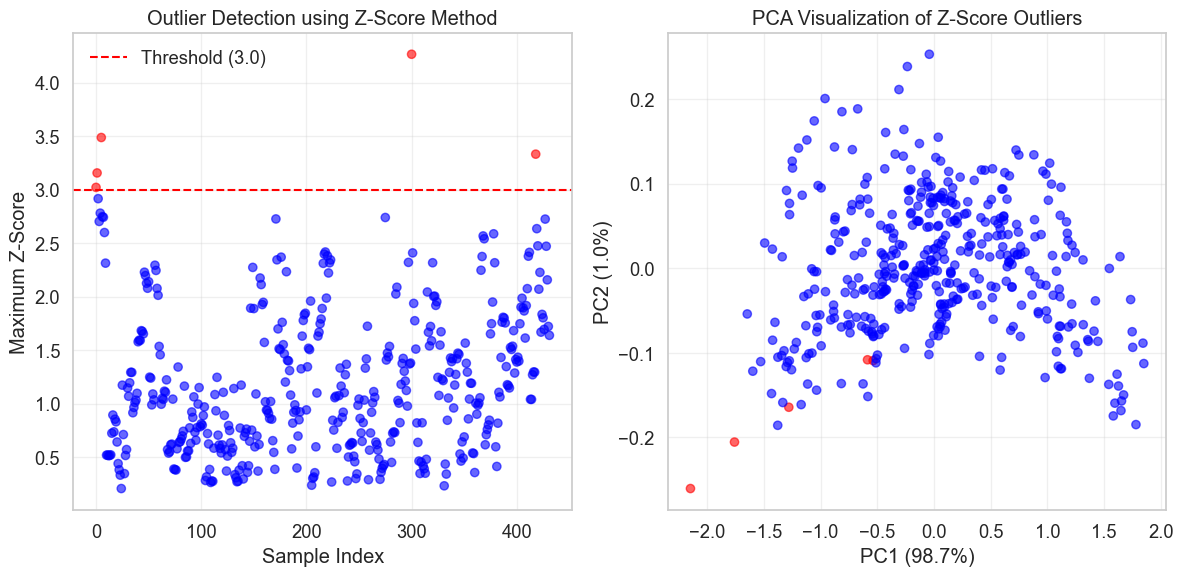

In [11]:
# Visualize Z-score results
plt.figure(figsize=(12, 6))

# Plot 1: Z-scores with threshold
plt.subplot(1, 2, 1)
plt.scatter(range(len(max_zscores)), max_zscores,
            c=['red' if x else 'blue' for x in zscore_outliers], alpha=0.6)
plt.axhline(y=3.0, color='r', linestyle='--', label=f'Threshold (3.0)')
plt.xlabel('Sample Index')
plt.ylabel('Maximum Z-Score')
plt.title('Outlier Detection using Z-Score Method')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: PCA visualization with outliers highlighted
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_spectral)

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=['red' if x else 'blue' for x in zscore_outliers], alpha=0.6)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title('PCA Visualization of Z-Score Outliers')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Remove outliers from X and y
if zscore_outlier_count > 0:
    print(f"\nRemoving {zscore_outlier_count} outliers from the dataset...")

    # Get non-outlier indices
    non_outlier_indices = np.where(~zscore_outliers)[0]

    X_filtered = X.iloc[non_outlier_indices]
    y_filtered = y.iloc[non_outlier_indices]

    print(f"Dataset shape after removing outliers: {X_filtered.shape}")

    X = X_filtered
    y = y_filtered


Removing 5 outliers from the dataset...
Dataset shape after removing outliers: (427, 128)


## 3. Spectral Preprocessing Techniques

### 2.1 Standard Normal Variate (SNV)

In [13]:
class SNVTransformer(BaseEstimator, TransformerMixin):
    """
    Standard Normal Variate transformation for spectral data.
    
    For each spectrum (row), this subtracts the mean and divides by the standard deviation.
    This helps reduce scatter effects and baseline variations in NIR spectroscopy data.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_transformed = X.copy()

            numeric_cols = X.select_dtypes(include=['number']).columns

            if len(numeric_cols) == 0:
                raise ValueError("No numeric columns found for SNV transformation")

            # Apply SNV only to numeric columns
            for idx, row in X.iterrows():
                row_values = row[numeric_cols].values
                row_mean = np.mean(row_values)
                row_std = np.std(row_values)

                X_transformed.loc[idx, numeric_cols] = (row_values - row_mean) / row_std

            return X_transformed
        else:
            X_array = X.copy()
            X_snv = np.zeros_like(X_array)

            # Apply SNV
            for i in range(X_array.shape[0]):
                X_snv[i, :] = (X_array[i, :] - np.mean(X_array[i, :])) / np.std(X_array[i, :])

            return X_snv

X_numeric = X.select_dtypes(include=['number'])
snv = SNVTransformer()
X_snv = snv.transform(X_numeric)

### 2.2 Savitzky-Golay Derivatives

In [14]:
class SavGolTransformer(BaseEstimator, TransformerMixin):
    """
    Savitzky-Golay filter for spectral derivatives.
    
    Applies a polynomial smoothing filter and calculates derivatives.
    Derivatives help enhance spectral features and reduce baseline effects.
    
    The first derivative highlights areas of rapid change in the spectrum,
    while the second derivative can identify peak locations more precisely.
    In NIR spectroscopy, derivatives help to enhance small spectral features
    and reduce baseline variations caused by scattering effects.
    
    Parameters:
    -----------
    window_length : int
        The length of the filter window (must be odd)
    polyorder : int
        The order of the polynomial used to fit the samples
    deriv : int
        The order of the derivative to compute
    """
    def __init__(self, window_length=15, polyorder=2, deriv=1):
        self.window_length = window_length
        self.polyorder = polyorder
        self.deriv = deriv

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_transformed = X.copy()

            numeric_cols = X.select_dtypes(include=['number']).columns

            if len(numeric_cols) == 0:
                raise ValueError("No numeric columns found for Savitzky-Golay filtering")

            X_numeric = X[numeric_cols].values
            X_sg = np.zeros_like(X_numeric)

            # Apply Savitzky-Golay filter to each row of numeric data
            for i in range(X_numeric.shape[0]):
                X_sg[i, :] = signal.savgol_filter(
                    X_numeric[i, :],
                    window_length=self.window_length,
                    polyorder=self.polyorder,
                    deriv=self.deriv
                )

            X_transformed[numeric_cols] = X_sg

            return X_transformed
        else:
            X_array = X.copy()
            X_sg = np.zeros_like(X_array)

            for i in range(X_array.shape[0]):
                X_sg[i, :] = signal.savgol_filter(
                    X_array[i, :],
                    window_length=self.window_length,
                    polyorder=self.polyorder,
                    deriv=self.deriv
                )

            return X_sg

X_spectral = X[wavelength_cols]
sg1 = SavGolTransformer(window_length=15, polyorder=2, deriv=1)
X_sg1 = sg1.transform(X_spectral)

sg2 = SavGolTransformer(window_length=15, polyorder=2, deriv=2)
X_sg2 = sg2.transform(X_spectral)

### 2.3 Multiplicative Scatter Correction (MSC)

In [15]:
class MSCTransformer(BaseEstimator, TransformerMixin):
    """
    Multiplicative Scatter Correction for spectral data.
    
    Corrects for scatter effects by regressing each spectrum against a reference 
    spectrum (usually the mean) and then applying the linear correction using 
    the calculated slope and intercept.
    
    This technique is commonly used in NIR spectroscopy to reduce the effects of
    light scattering caused by physical differences in samples, such as particle
    size, surface texture, and sample thickness.
    """
    def __init__(self):
        self.mean_spectrum = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            numeric_cols = X.select_dtypes(include=['number']).columns

            if len(numeric_cols) == 0:
                raise ValueError("No numeric columns found for MSC transformation")

            # Calculate mean spectrum only from numeric columns
            X_numeric = X[numeric_cols].values
            self.mean_spectrum = np.mean(X_numeric, axis=0)
        else:
            X_array = X.copy()
            self.mean_spectrum = np.mean(X_array, axis=0)

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_transformed = X.copy()

            numeric_cols = X.select_dtypes(include=['number']).columns

            if len(numeric_cols) == 0:
                raise ValueError("No numeric columns found for MSC transformation")

            X_numeric = X[numeric_cols].values
            X_msc = np.zeros_like(X_numeric)

            # Apply MSC transformation to each row
            for i in range(X_numeric.shape[0]):
                slope, intercept = np.polyfit(self.mean_spectrum, X_numeric[i, :], 1)
                # Apply correction
                X_msc[i, :] = (X_numeric[i, :] - intercept) / slope

            X_transformed[numeric_cols] = X_msc

            return X_transformed
        else:
            X_array = X.copy()
            X_msc = np.zeros_like(X_array)

            for i in range(X_array.shape[0]):
                slope, intercept = np.polyfit(self.mean_spectrum, X_array[i, :], 1)
                X_msc[i, :] = (X_array[i, :] - intercept) / slope

            return X_msc

wavelength_cols = [col for col in X.columns if col.replace('.', '').isdigit()]
X_spectral = X[wavelength_cols]

msc = MSCTransformer()
msc.fit(X_spectral)
X_msc = msc.transform(X_spectral)

### 3.4 Visualize Preprocessed Spectra

Wavelengths shape: (125,)
X_spectral shape: (427, 125)
X_snv shape: (427, 126)
X_sg1 shape: (427, 125)
X_sg2 shape: (427, 125)
X_msc shape: (427, 125)


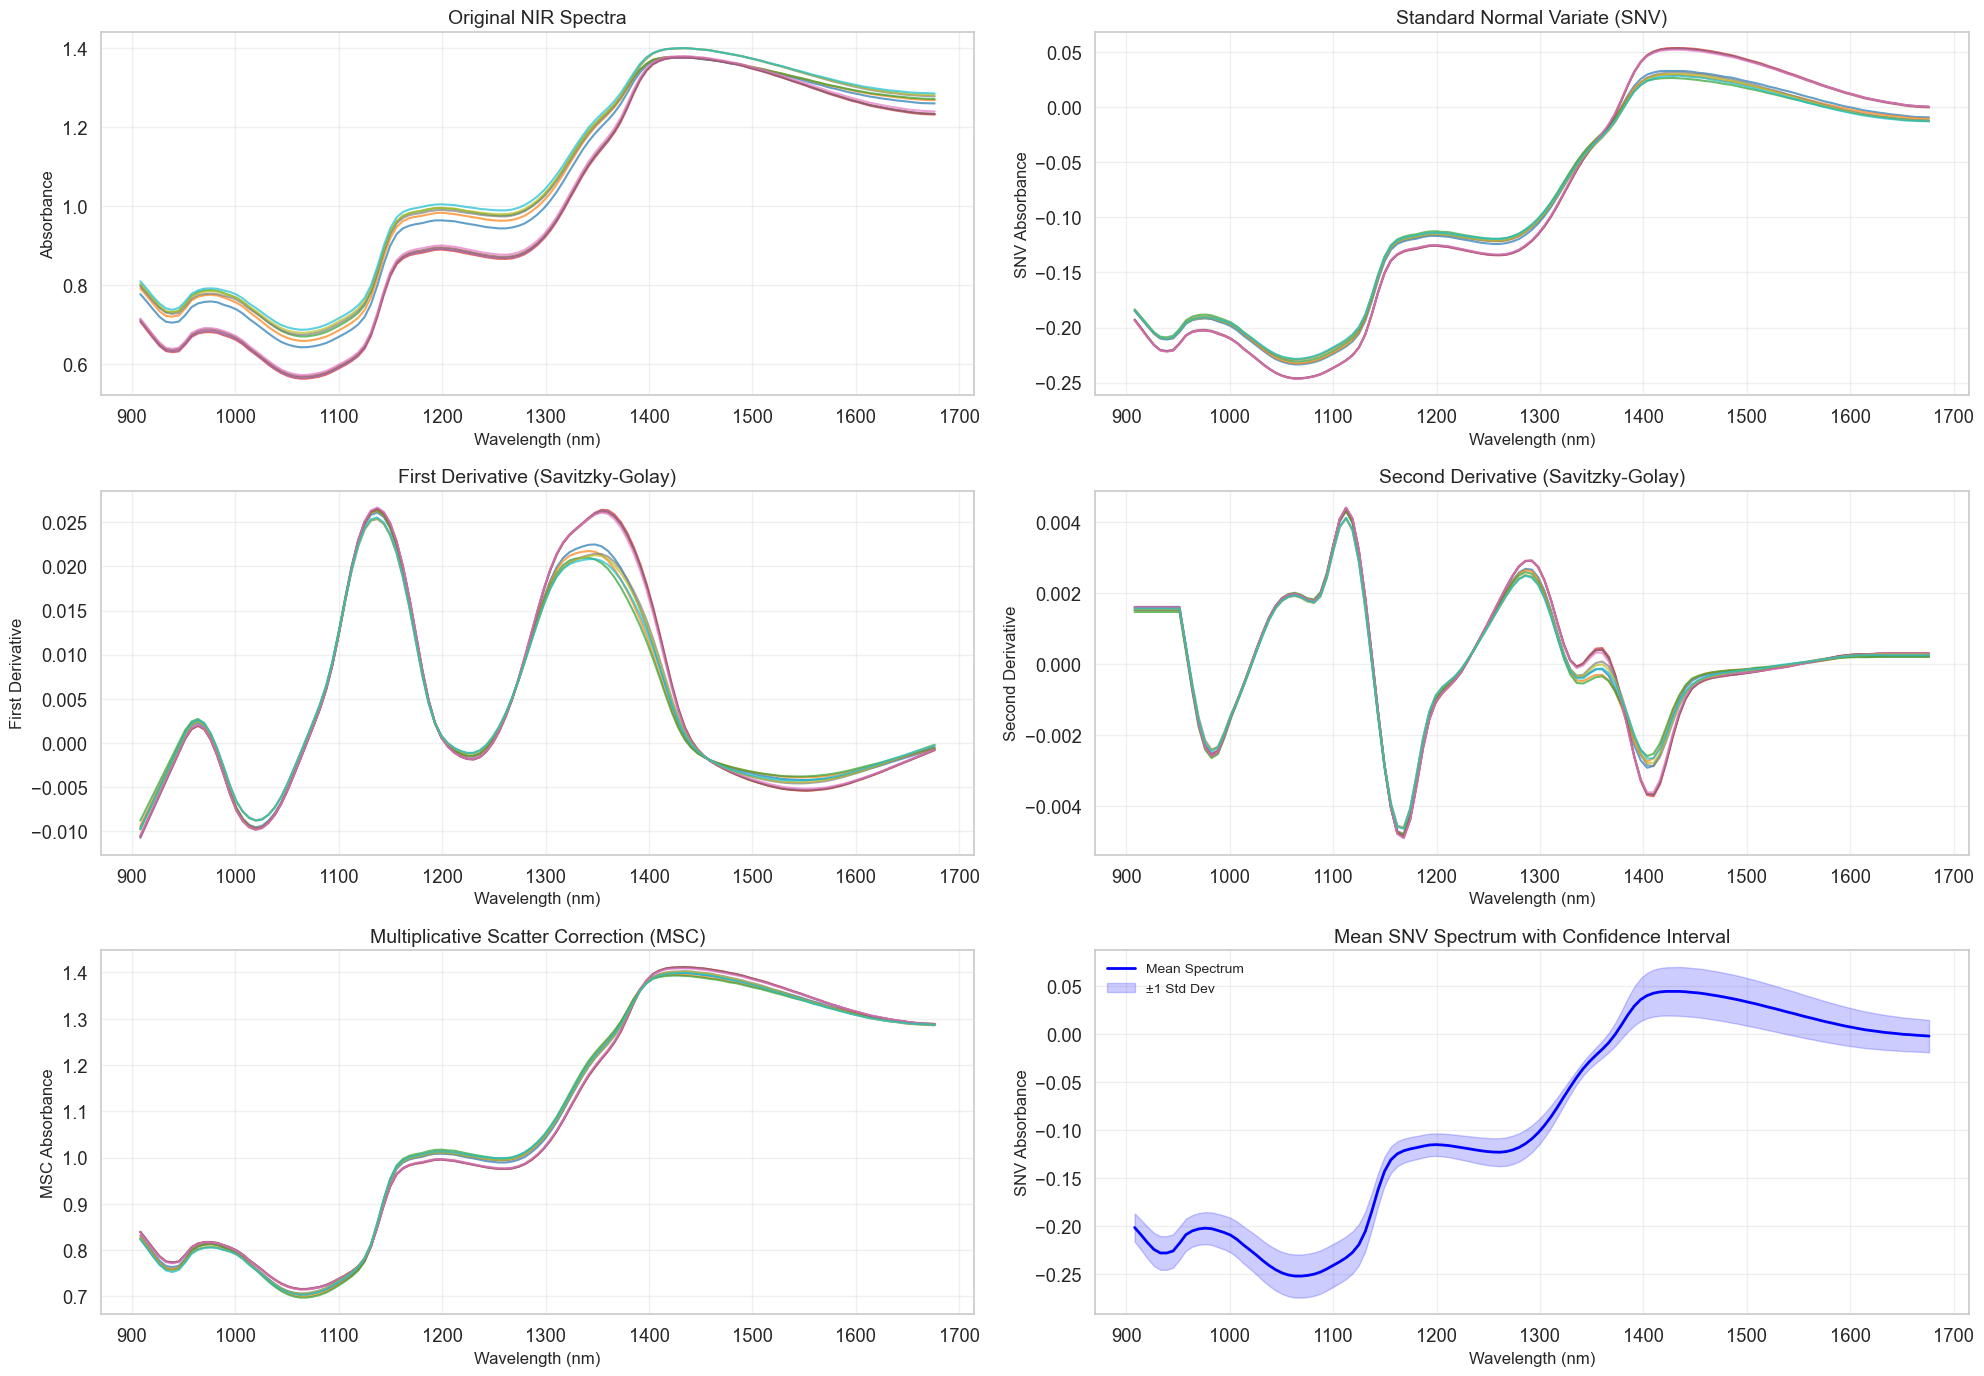

In [16]:
# Get dimensions of datasets
print(f"Wavelengths shape: {wavelengths.shape}")
print(f"X_spectral shape: {X_spectral.shape}")
print(f"X_snv shape: {X_snv.shape}")
print(f"X_sg1 shape: {X_sg1.shape}")
print(f"X_sg2 shape: {X_sg2.shape}")
print(f"X_msc shape: {X_msc.shape}")

# Get a subset of sample indices for visualization (to reduce clutter)
sample_indices = X_spectral.index[:10]


fig, axs = plt.subplots(3, 2, figsize=(20, 14))

# Plot original spectra
ax = axs[0, 0]
for idx in sample_indices:
    ax.plot(wavelengths, X_spectral.loc[idx].values, alpha=0.7)
ax.set_title('Original NIR Spectra', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Absorbance', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot SNV spectra
ax = axs[0, 1]
snv_spectral_cols = [col for col in X_snv.columns if col.replace('.', '').isdigit()]
for idx in sample_indices:
    ax.plot(wavelengths, X_snv.loc[idx, snv_spectral_cols].values, alpha=0.7)
ax.set_title('Standard Normal Variate (SNV)', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('SNV Absorbance', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot first derivative spectra
ax = axs[1, 0]
for idx in sample_indices:
    ax.plot(wavelengths, X_sg1.loc[idx].values, alpha=0.7)
ax.set_title('First Derivative (Savitzky-Golay)', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('First Derivative', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot second derivative
ax = axs[1, 1]
for idx in sample_indices:
    ax.plot(wavelengths, X_sg2.loc[idx].values, alpha=0.7)
ax.set_title('Second Derivative (Savitzky-Golay)', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('Second Derivative', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot MSC spectra
ax = axs[2, 0]
for idx in sample_indices:
    ax.plot(wavelengths, X_msc.loc[idx].values, alpha=0.7)
ax.set_title('Multiplicative Scatter Correction (MSC)', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('MSC Absorbance', fontsize=12)
ax.grid(True, alpha=0.3)

# Add mean spectra with standard deviation for SNV as an example
ax = axs[2, 1]
mean_spectrum = X_snv[snv_spectral_cols].mean(axis=0).values
std_spectrum = X_snv[snv_spectral_cols].std(axis=0).values

# Plot mean spectrum
ax.plot(wavelengths, mean_spectrum, 'b-', linewidth=2, label='Mean Spectrum')
# Add confidence interval
ax.fill_between(wavelengths,
                mean_spectrum - std_spectrum,
                mean_spectrum + std_spectrum,
                color='blue', alpha=0.2,
                label='±1 Std Dev')
ax.set_title('Mean SNV Spectrum with Confidence Interval', fontsize=14)
ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('SNV Absorbance', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Principal Component Analysis (PCA)

In [17]:
# Define functions for PCA and preprocessing
def preprocess_data(X):
    """Process data for PCA by handling categorical/string values"""
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(exclude=['number']).columns

    # Exclude datetime columns - handle string/categorical columns
    datetime_cols = X.select_dtypes(include=['datetime']).columns
    categorical_cols = [col for col in categorical_cols if col not in datetime_cols]

    # If there are no categorical columns, just return the numeric data
    if len(categorical_cols) == 0:
        return X[numeric_cols]

    # Apply One-Hot Encoding for categorical variables
    print(f"Applying encoding for categorical columns: {categorical_cols}")
    X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

    # Combine numeric and encoded categorical data
    X_processed = pd.concat([X[numeric_cols], X_encoded], axis=1)

    print(f"Original data shape: {X.shape}")
    print(f"Shape after encoding: {X_processed.shape}")

    return X_processed

def apply_pca(X_data, n_components=10):
    """Apply PCA to preprocessed data"""
    # Ensure working with numeric data
    if isinstance(X_data, pd.DataFrame):
        # Apply preprocessing to handle categorical data
        X_data_processed = preprocess_data(X_data)
    else:
        # For numpy arrays, assume data is already numeric
        X_data_processed = X_data

    # Check for infinite or NaN values that would cause PCA to fail
    X_array = X_data_processed.values if isinstance(X_data_processed, pd.DataFrame) else X_data_processed

    if np.isnan(X_array).any() or np.isinf(X_array).any():
        print("Warning: NaN or infinite values found. Replacing them with 0.")
        X_array = np.nan_to_num(X_array)
        # If original was DataFrame, convert back
        if isinstance(X_data_processed, pd.DataFrame):
            X_data_processed = pd.DataFrame(X_array, index=X_data_processed.index,
                                          columns=X_data_processed.columns)
        else:
            X_data_processed = X_array

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_data_processed)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    return X_pca, pca, explained_variance, cumulative_variance, X_data_processed

# Apply PCA to each preprocessed dataset
X_raw_pca, pca_raw, var_raw, cum_var_raw, X_raw_proc = apply_pca(X_spectral)
X_snv_pca, pca_snv, var_snv, cum_var_snv, X_snv_proc = apply_pca(X_snv)
X_sg1_pca, pca_sg1, var_sg1, cum_var_sg1, X_sg1_proc = apply_pca(X_sg1)
X_sg2_pca, pca_sg2, var_sg2, cum_var_sg2, X_sg2_proc = apply_pca(X_sg2)
X_msc_pca, pca_msc, var_msc, cum_var_msc, X_msc_proc = apply_pca(X_msc)

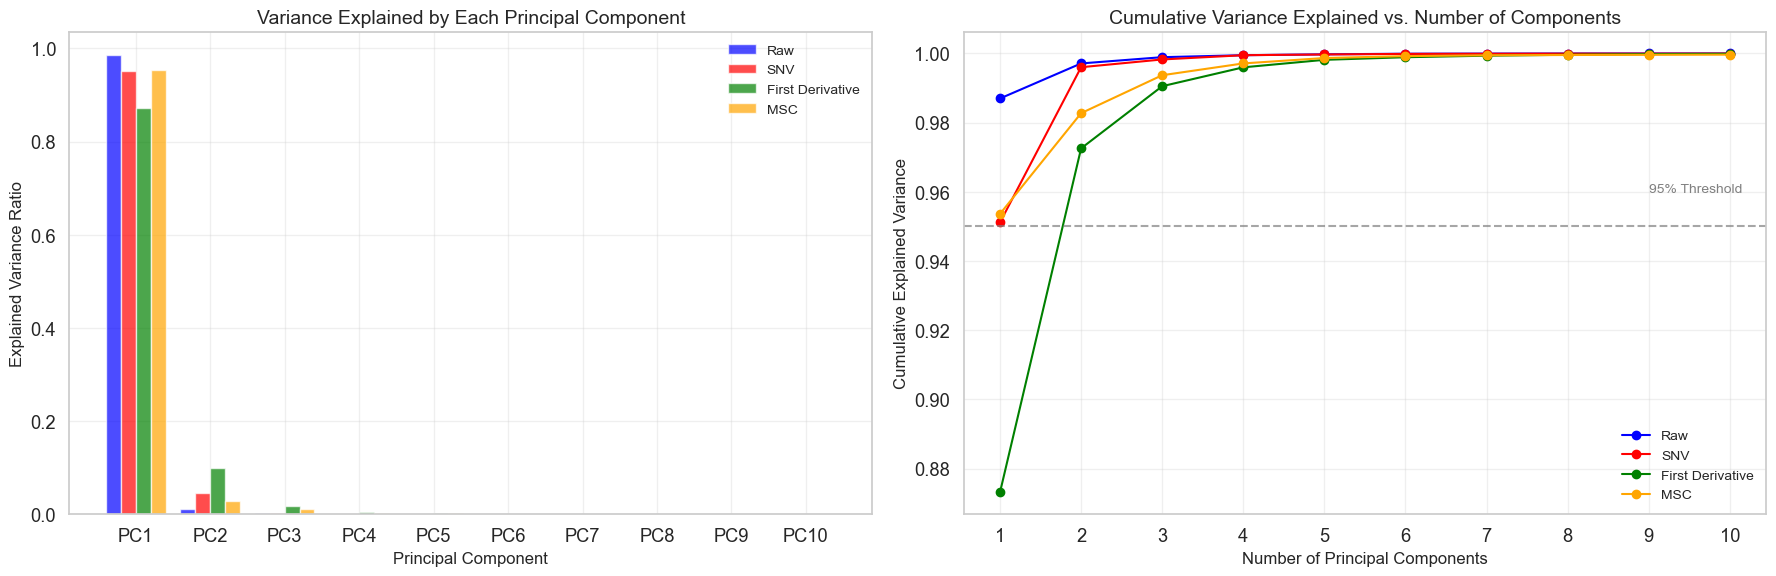

In [18]:
# Visualize PCA explained variance
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

bar_width = 0.2
x = np.arange(10)

ax[0].bar(x - 1.5*bar_width, var_raw[:10], width=bar_width, color='blue', alpha=0.7, label='Raw')
ax[0].bar(x - 0.5*bar_width, var_snv[:10], width=bar_width, color='red', alpha=0.7, label='SNV')
ax[0].bar(x + 0.5*bar_width, var_sg1[:10], width=bar_width, color='green', alpha=0.7, label='First Derivative')
ax[0].bar(x + 1.5*bar_width, var_msc[:10], width=bar_width, color='orange', alpha=0.7, label='MSC')

ax[0].set_xlabel('Principal Component', fontsize=12)
ax[0].set_ylabel('Explained Variance Ratio', fontsize=12)
ax[0].set_title('Variance Explained by Each Principal Component', fontsize=14)
ax[0].set_xticks(x)
ax[0].set_xticklabels([f'PC{i+1}' for i in range(10)])
ax[0].legend(fontsize=10)
ax[0].grid(True, alpha=0.3)

# Plot cumulative explained variance
ax[1].plot(np.arange(1, 11), cum_var_raw[:10], 'o-', color='blue', label='Raw')
ax[1].plot(np.arange(1, 11), cum_var_snv[:10], 'o-', color='red', label='SNV')
ax[1].plot(np.arange(1, 11), cum_var_sg1[:10], 'o-', color='green', label='First Derivative')
ax[1].plot(np.arange(1, 11), cum_var_msc[:10], 'o-', color='orange', label='MSC')

# Add horizontal line at 95% explained variance
ax[1].axhline(y=0.95, color='gray', linestyle='--', alpha=0.7)
ax[1].text(9, 0.96, '95% Threshold', color='gray', fontsize=10)

ax[1].set_xlabel('Number of Principal Components', fontsize=12)
ax[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
ax[1].set_title('Cumulative Variance Explained vs. Number of Components', fontsize=14)
ax[1].set_xticks(np.arange(1, 11))
ax[1].grid(True, alpha=0.3)
ax[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

### 3.1 PCA Scores Plot

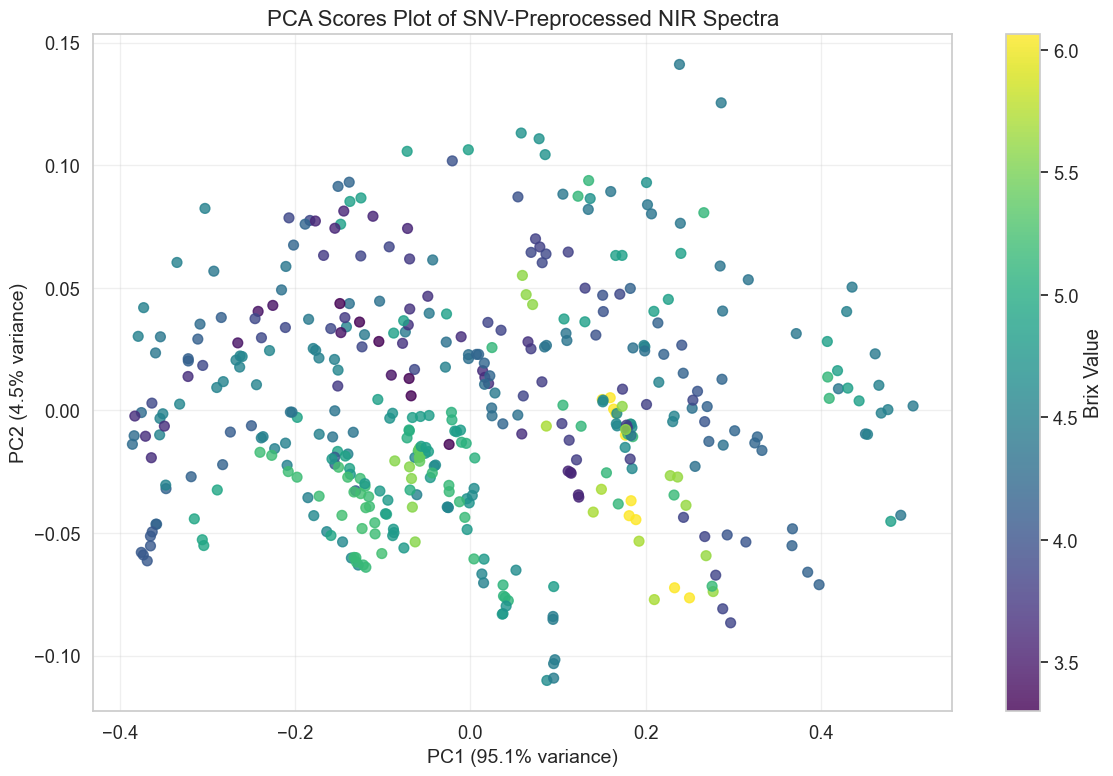

In [19]:
plt.figure(figsize=(12, 8))

# Create scatter plot with Brix color coding
scatter = plt.scatter(X_snv_pca[:, 0], X_snv_pca[:, 1], 
                      c=y, cmap='viridis', alpha=0.8, s=50)

plt.xlabel(f'PC1 ({var_snv[0]*100:.1f}% variance)', fontsize=14)
plt.ylabel(f'PC2 ({var_snv[1]*100:.1f}% variance)', fontsize=14)
plt.title('PCA Scores Plot of SNV-Preprocessed NIR Spectra', fontsize=16)
plt.colorbar(scatter, label='Brix Value')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.2 PCA Loadings Plot

Wavelengths shape: (125,)
Loadings shape for first component: (126,)
Dimension mismatch detected. Adjusting wavelengths array.
Number of spectral columns in processed data: 125
Adjusted dimensions - Wavelengths: (125,), Loadings: (125,)


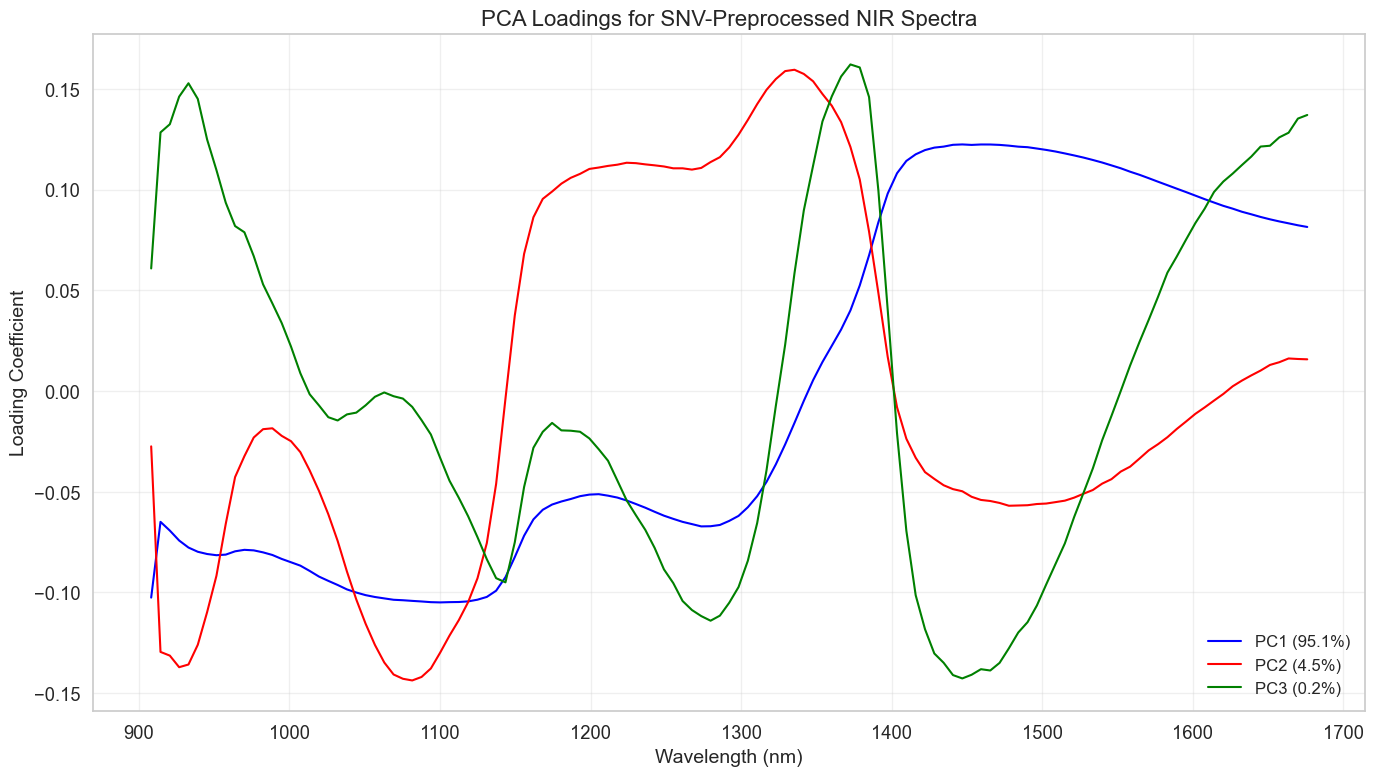

In [20]:
plt.figure(figsize=(14, 8))

# Get loadings from the PCA model
loadings = pca_snv.components_

# Check if there's a dimension mismatch
print(f"Wavelengths shape: {wavelengths.shape}")
print(f"Loadings shape for first component: {loadings[0].shape}")

# Make sure wavelengths and loadings have the same length
wavelengths_plot = wavelengths
if wavelengths.shape[0] != loadings[0].shape[0]:
    print("Dimension mismatch detected. Adjusting wavelengths array.")
    # Get the spectral columns from processed data
    snv_spectral_cols = [col for col in X_snv_proc.columns if col.replace('.', '').isdigit()]
    print(f"Number of spectral columns in processed data: {len(snv_spectral_cols)}")
    
    # Use only the wavelengths that match our spectral columns
    if len(wavelengths) > len(snv_spectral_cols):
        wavelengths_plot = wavelengths[:len(snv_spectral_cols)]
    else:
        # If we need more wavelengths, we can interpolate or use a subset of loadings
        loadings = loadings[:, :wavelengths.shape[0]]
    
    print(f"Adjusted dimensions - Wavelengths: {wavelengths_plot.shape}, Loadings: {loadings[0].shape}")

# Plot loadings for the first 3 PCs
plt.plot(wavelengths_plot, loadings[0], 'b-', label=f'PC1 ({var_snv[0]*100:.1f}%)')
plt.plot(wavelengths_plot, loadings[1], 'r-', label=f'PC2 ({var_snv[1]*100:.1f}%)')
plt.plot(wavelengths_plot, loadings[2], 'g-', label=f'PC3 ({var_snv[2]*100:.1f}%)')

plt.xlabel('Wavelength (nm)', fontsize=14)
plt.ylabel('Loading Coefficient', fontsize=14)
plt.title('PCA Loadings for SNV-Preprocessed NIR Spectra', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Data Partitioning

In [21]:
X = X.drop(["plant", "Timestamp"], axis=1)

In [22]:
# Check for missing values
print(f"NaN values in X: {X.isna().sum().sum()}")
print(f"NaN values in y: {y.isna().sum()}")

NaN values in X: 0
NaN values in y: 0


Brix range: 3.30 to 6.07

Distribution of Brix categories:
Category 1 (3.3-3.8): 44 samples (10.3%)
Category 2 (3.8-4.2): 84 samples (19.7%)
Category 3 (4.2-4.6): 121 samples (28.3%)
Category 4 (4.6-5.0): 78 samples (18.3%)
Category 5 (5.0-6.1): 94 samples (22.0%)


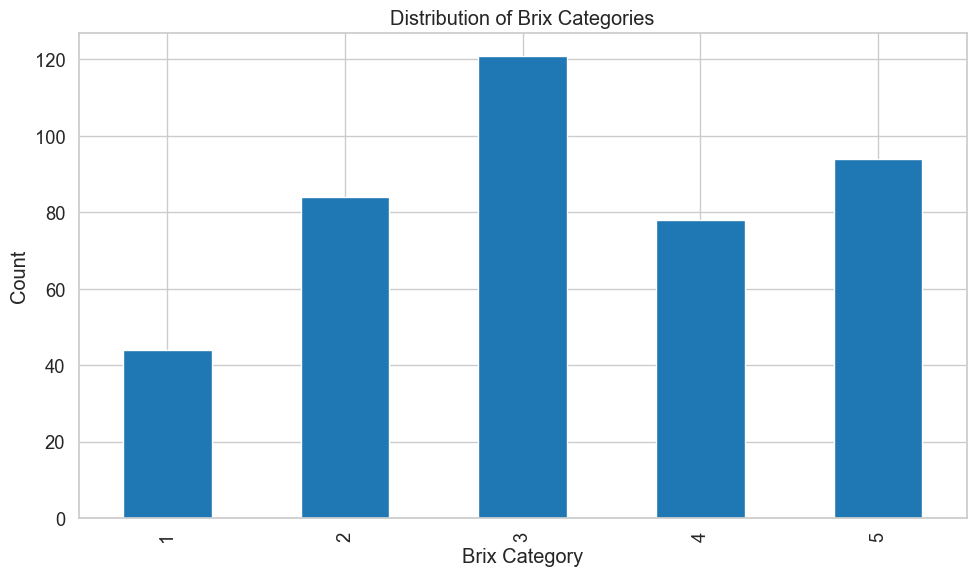

In [23]:
# Create Brix categories for visualization and data inspection
brix_min = y.min()
brix_max = y.max()
print(f"Brix range: {brix_min:.2f} to {brix_max:.2f}")

# Create 5 bins with custom edges
bins = [brix_min, 3.8, 4.2, 4.6, 5.0, brix_max]
labels = [1, 2, 3, 4, 5]

# Create Brix category column
y_cat = pd.cut(y, bins=bins, labels=labels)

# Display the distribution
print("\nDistribution of Brix categories:")
for category, count in y_cat.value_counts().sort_index().items():
    range_str = f"{bins[category-1]:.1f}-{bins[category]:.1f}"
    percentage = 100 * count / len(y)
    print(f"Category {category} ({range_str}): {count} samples ({percentage:.1f}%)")

# Visualize the distribution
plt.figure(figsize=(10, 6))
y_cat.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Brix Categories')
plt.xlabel('Brix Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [24]:
# Split data into training+validation and test sets (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Further split training+validation into training and validation sets (75/25)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42)

# Print the shapes of each set
print(f"\nTraining set: {X_train.shape} samples")
print(f"Validation set: {X_val.shape} samples")
print(f"Test set: {X_test.shape} samples")

# Check the distribution in each split
print("\nBrix category proportions in training set:")
train_cat = pd.cut(y_train, bins=bins, labels=labels)
for category, count in train_cat.value_counts().sort_index().items():
    percentage = 100 * count / len(y_train)
    print(f"Category {category}: {percentage:.1f}%")

print("\nBrix category proportions in validation set:")
val_cat = pd.cut(y_val, bins=bins, labels=labels)
for category, count in val_cat.value_counts().sort_index().items():
    percentage = 100 * count / len(y_val)
    print(f"Category {category}: {percentage:.1f}%")

print("\nBrix category proportions in test set:")
test_cat = pd.cut(y_test, bins=bins, labels=labels)
for category, count in test_cat.value_counts().sort_index().items():
    percentage = 100 * count / len(y_test)
    print(f"Category {category}: {percentage:.1f}%")


Training set: (255, 126) samples
Validation set: (86, 126) samples
Test set: (86, 126) samples

Brix category proportions in training set:
Category 1: 11.4%
Category 2: 19.2%
Category 3: 27.8%
Category 4: 18.4%
Category 5: 21.6%

Brix category proportions in validation set:
Category 1: 9.3%
Category 2: 17.4%
Category 3: 29.1%
Category 4: 18.6%
Category 5: 23.3%

Brix category proportions in test set:
Category 1: 8.1%
Category 2: 23.3%
Category 3: 29.1%
Category 4: 17.4%
Category 5: 22.1%


In [25]:
# Extract indices for later use
train_indices = X_train.index.tolist()
val_indices = X_val.index.tolist()
test_indices = X_test.index.tolist()

data_splits = {
    'train_indices': train_indices,
    'val_indices': val_indices,
    'test_indices': test_indices,
    'wavelengths': wavelengths.tolist()
}
joblib.dump(data_splits, 'nir_tomato_data_splits.joblib')

# Save preprocessed df
processed_dataset = {
    'X': X,
    'y': y,
    'data_splits': data_splits
}

joblib.dump(processed_dataset, 'nir_tomato_processed_dataset.joblib')

['nir_tomato_processed_dataset.joblib']